# Setting up a latent function Gaussian Process for H(z)

In [74]:
# import set 
using Turing
using Distances
using LinearAlgebra
using LimberJack
using Interpolations
using GaussianProcess
using Plots
using QuadGK
using BlockDiagonals
using CSV
using DataFrames
using PrettyTables

### Collate data

In [75]:
# setting a cosmology for the fake data, all fiducial cosmo parameters 
cosmo1 = Cosmology();
rd_fid = 99.0792;
rd_red = 147.09;

# assumed parameter distributions
omegam_dist = Uniform(0.25, 0.35);
h0_dist = Uniform(0.6, 0.8);
s8_dist = Uniform(0.6, 0.9);
rd_dist = Uniform(90, 110);
M_dist = Normal(-19.3, 0.1);

#### Generate fake data

In [76]:
# hz data
function data_hz()
    z = [
        0.07, 0.09, 0.12, 0.17, 0.179, 0.199, 0.2,
        0.27, 0.28, 0.352, 0.38, 0.3802, 0.4,
        0.4004, 0.4247, 0.44, 0.4497, 0.47, 0.4783,
        0.48, 0.51, 0.593, 0.6, 0.61, 0.68, 0.73,
        0.781, 0.875, 0.88, 0.9, 1.037, 1.3,
        1.363, 1.43, 1.53, 1.75, 1.965
    ]

    data = [
        69.0, 69.0, 68.6, 83.0, 75.0, 75.0, 72.9,
        77.0, 88.8, 83.0, 81.5, 83.0, 95.0, 77.0,
        87.1, 82.6, 92.8, 89.0, 80.9, 97.0, 90.4,
        104.0, 87.9, 97.3, 92.0, 97.3, 105.0,
        125.0, 90.0, 117.0, 154.0, 168.0, 160.0,
        177.0, 140.0, 202.0, 186.5
    ]

    err = [
        19.6, 12.0, 26.2, 8.0, 4.0, 5.0, 29.6,
        14.0, 36.6, 14.0, 1.9, 13.5, 17.0, 10.2,
        11.2, 7.8, 12.9, 23.0, 9.0, 62.0, 1.9,
        13.0, 6.1, 2.1, 8.0, 7.0, 12.0, 17.0,
        40.0, 23.0, 20.0, 17.0, 33.6, 18.0,
        14.0, 40.0, 50.4
    ]

    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end

    return (
        data_name = "data_hz",
        z = z,
        data = data,
        err = err,
        cov = cov
    )
end

# fs8 data
function data_fs8()

z  = [0.3, 0.51, 0.71, 0.92, 1.32, 1.49]

data  = [0.37784, 0.515897, 0.48384, 0.422208, 0.37468, 0.435]

fs8_upper = [0.4723, 0.572693, 0.539136, 0.470586, 0.418064, 0.48]
fs8_lower = [0.28338, 0.449635, 0.428544, 0.378228, 0.343128, 0.39]
err_up = fs8_upper .- data
err_low = data .- fs8_lower
err = (fs8_upper .- fs8_lower) ./ 2

cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    
    return (data_name = "data_fs8", z = z, data = data, err = err, cov = cov)
end

# # aiso data
# function fakedata_aiso()
#     z  = sort(2.5 .* rand(12)) 
#     dvz_cb = ((z .* LimberJack.CLIGHT_HMPC) .* ((cosmo1.chi(z)) .^ 2)) ./ (cosmo1.cpar.h .* 100 .* Ez(cosmo1, z))
#     data = (dvz_cb .^ (1/3)) ./ rd_fid
#     err = 0.1 .* data
#     cov = zeros(length(z), length(z))
#     for i in 1:length(z)
#         cov[i, i] = err[i]^2
#     end
#     return(data_name = "fakedata_aiso", z = z, data = data, cov = cov)
# end

# # aap data
# function fakedata_aap()
#     z = sort([[0.01, 0.02, 0.03, 0.05, 0.06, 0.07] ; (2.5 .* rand(4))])
#     data = LimberJack.CLIGHT_HMPC ./ (cosmo1.cpar.h .* 100 .* Ez(cosmo1, z) .* (cosmo1.chi(z)))
#     err = 0.1 .* data
#     cov = zeros(length(z), length(z))
#     for i in 1:length(z)
#         cov[i, i] = err[i]^2
#     end
#     return(data_name = "fakedata_aap", z = z, data = data, cov = cov)
# end


# supernovae data
# function fakedata_mu()
#     z = sort([[0.01, 0.02, 0.05, 0.09] ; (2.5 .* rand(4))])
#     zhel = z .+ 0.0002
#     d_lum = (1 .+ zhel) .* (cosmo1.chi(z))
#     mu_initz = 5 .* log10.( abs.(d_lum) ./ 10 ) .+ 25
#     M_samp = -19.3 + 5*log10(LimberJack.CLIGHT_HMPC/(cosmo1.cpar.h*100))
#     data = mu_initz .+ 19.3 .+ M_samp 
#     # data = 5 .* log10.(d_lum) .+ 25 .+ 0.5
#     err = 0.1 .* data
#     cov = zeros(length(z), length(z))
#     for i in 1:length(z)
#         cov[i, i] = err[i]^2
#     end
#     return(data_name = "fakedata_mu", z = z, zhel = zhel, data = data, cov = cov)
# end


data_fs8 (generic function with 1 method)

In [77]:
datafs8 = data_fs8();

In [78]:
# correlation matrix
function cov_to_cor(covariance)
    std_devs = sqrt.(diag(covariance))
    return covariance ./ (std_devs * std_devs')
end

cov_to_cor (generic function with 1 method)

In [79]:
function data_DESI()
    # DESI data
    z_dvrd = [0.51, 0.706, 0.934, 1.321, 1.484]
    z_dhdm = [0.51, 0.706, 0.934, 1.321, 1.484]
    z_fs8 = [0.3, 0.51, 0.71, 0.92, 1.32, 1.49]
    z = [z_dvrd;z_dhdm;z_fs8]
    data_dvrd = [13.58758434, 17.35069094, 21.57563956, 27.60085612, 30.51190063]
    data_dhdm = [21.86294686, 19.45534918, 17.64149464, 14.17602155, 12.81699964]
    data_fs8 = [0.37784, 0.515897, 0.48384, 0.422208, 0.37468, 0.435]

    
    data = 
    [7.788174, 3.053800, 0.37784,   # BGS (z=0.30)
    12.514437, 1.637266, 0.515897, # LRG1 (z=0.51)
    15.675560, 1.165867, 0.48384,  # LRG2 (z=0.71)
    19.676985, 0.844996, 0.422208, # LRG3 (z=0.92)
    23.861806, 0.470709, 0.37468,  # ELG2 (z=1.32)
    25.708520, 0.426508, 0.435]   # QSO (z=1.49)

    # Full 18x18 Covariance Matrix for DESI 2024 Year 1 
    # Variables: [DV/rd, DH/DM, fσs8] per redshift bin
    # Source: arXiv:2411.12021 Appendix A
    C_total = zeros(18, 18);

    # BGS z=0.30
    C_total[1:3, 1:3] = 1e-4 * [
        1314.664401 -142.669742  109.427163;
        -142.669742  829.170940 -158.101737;
        109.427163 -158.101737   88.510877
    ]

    # LRG1 z=0.51
    C_total[4:6, 4:6] = 1e-4 * [
        541.309833   48.425593   -4.652853;
        48.425593   97.249820  -34.923265;
        -4.652853  -34.923265   41.295470
    ]

    # LRG2 z=0.71
    C_total[7:9, 7:9] = 1e-4 * [
        762.457717   39.781004   -1.896006;
        39.781004   36.344098  -17.341350;
        -1.896006  -17.341350   28.119682
    ]

    # LRG3 z=0.92
    C_total[10:12, 10:12] = 1e-4 * [
        847.499793   26.038900    3.257324;
        26.038900   16.251088  -10.044074;
        3.257324  -10.044074   22.370314
    ]

    # ELG2 z=1.32
    C_total[13:15, 13:15] = 1e-4 * [
    2342.506886   26.159601   13.521001;
        26.159601   10.309303   -6.654663;
        13.521001   -6.654663   13.997473
    ]

    # QSO z=1.49
    C_total[16:18, 16:18] = 1e-4 * [
    3013.788566   -2.205101   36.332110;
        -2.205101    5.845806   -6.747133;
        36.332110   -6.747133   19.785658
    ]

    full_covariance = cov_to_cor(C_total);
#pretty_table(full_covariance)

    cov_final = C_total
    for k in 1:6
        cov_final[3*k,3*k] = datafs8.cov[k,k]
    end

    for h in 1:6
        cov_final[(3*h)-2,3*h] = sqrt(cov_final[3*h,3*h] * C_total[(3*h)-2,(3*h)-2]) * full_covariance[(3*h)-2,3*h]
        cov_final[(3*h)-1,3*h] = sqrt(cov_final[3*h,3*h] * C_total[(3*h)-1,(3*h)-1]) * full_covariance[(3*h)-1,3*h]
        cov_final[3*h,(3*h)-2] = sqrt(cov_final[3*h,3*h] * C_total[(3*h)-2,(3*h)-2]) * full_covariance[(3*h)-2,3*h]
        cov_final[3*h,(3*h)-1] = sqrt(cov_final[3*h,3*h] * C_total[(3*h)-1,(3*h)-1]) * full_covariance[(3*h)-1,3*h]
    end

    cov = cov_final
    
    err_arr = sqrt.(diag(cov))
    err_dvrd = err_arr[1:3:end]
    err_dhdm = err_arr[2:3:end]
    err_fs8 = err_arr[3:3:end]

    return(data_name = "data_DESI", 
    z = z, z_dvrd = z_dvrd, z_dhdm = z_dhdm, z_fs8 = z_fs8,
     data = data, data_dvrd = data_dvrd, data_dhdm = data_dhdm, data_fs8 = data_fs8, 
     err_dvrd = err_dvrd, err_dhdm = err_dhdm, err_fs8 = err_fs8, cov = cov)
end

data_DESI (generic function with 1 method)

In [125]:
# supernovae data
supernovae_raw = CSV.read("DES_Dovekie_HD.csv", DataFrame);
# Returns a new DataFrame
supernovae = filter(row -> row.MUERR <= 5, supernovae_raw)
function data_mu()
    z = supernovae[!,"zHD"]
    z_hel = supernovae[!,"zHEL"]
    data = supernovae[!,"MU"]
    err = supernovae[!,"MUERR"]
    
    cov = zeros(length(z), length(z))
    for i in 1:length(z)
        cov[i, i] = err[i]^2
    end
    
    return (data_name = "data_mu", z = z, data = data, err = err, cov = cov)
end

data_mu (generic function with 1 method)

In [126]:
dataDESI = data_DESI();
datamu = data_mu();
datahz = data_hz();

#### Putting data together

In [127]:
# errors
hz_err = datahz.err;
aiso_err = dataDESI.err_dvrd;
aap_err = dataDESI.err_dhdm;
fs8_err = datafs8.err;
mu_err = datamu.err;

### Functions for hz, dv/rd, dh/dm, fs8, mu

In [128]:
# outputs are arrays, not interpolators
function hz_from_ez(zarr, h0, ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())
    hz = ez_itp(zarr) .* (h0*100)
    #hzi = linear_interpolation(zarr, hz, extrapolation_bc=Line())
    return hz
end

function dm_from_ez(zarr, h0, ez)
    chis = similar(ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())

    for i in 1:length(zarr)
        zz = zarr[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end
    return chis
end


function fs8_from_ez(zarr, Ωm, σ8, h0, ez, cosmo_type)
    # initialising
    nz = length(zarr)
    z_max = maximum(zarr)
    x = log.(1 .+ zarr)
    a = @.(1/(1+zarr))
    dx = x[2]-x[1]
    
    aa = reverse(a)
    ee = reverse(ez)
    dd = zeros(cosmo_type, nz)
    yy = zeros(cosmo_type, nz)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]
    
    for i in 1:(nz-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx*yy[i] + (1+0.5*dx^2*A0*B0)*dd[i]
    end
    
    y = reverse(yy)
    d = reverse(dd)

    fs8zi =  -σ8 .* y./ (a.^2 .*ez.*d[1])
                                
                        
    return fs8zi
end


function dh(zarr, h0, ez)
    dhz = (LimberJack.CLIGHT_HMPC*100) ./ (hz_from_ez(zarr, h0, ez))
    return dhz
end

function dv(zarr, h0, ez)
    chis = similar(ez)
    ez_itp = LinearInterpolation(zarr, ez, extrapolation_bc=Line())

    for i in 1:length(zarr)
        zz = zarr[i]
        chis[i] = quadgk(z -> 1.0/ez_itp(z), 0.0, zz, rtol=1E-5)[1]
        chis[i] *= LimberJack.CLIGHT_HMPC / h0
    end
    
    dvs = similar(chis)
    for i in 1:length(zarr)
        zz = zarr[i]
        dvz_cbrt = zz * (LimberJack.CLIGHT_HMPC/(ez_itp(zz)*h0*100)) * (chis[i]^2)
        dvs[i] = sign(dvz_cbrt) * abs(dvz_cbrt)^(1/3)
    end

    return dvs
end

function a_ap(zarr, h0, ez)
  numer = dh(zarr, h0, ez) ./ dm_from_ez(zarr, h0, ez)
  return numer 
end

function a_iso(zarr, h0, rd, ez)
    numer = dv(zarr, h0, ez) ./ rd
    return numer 
end

function d_lum(zarr, h0, ez)
    dlz = (1 .+ zarr) .* dm_from_ez(zarr, h0, ez)
    return dlz
end

function mu1(zarr, h0, M, ez)
    muz = 5 .* log10.( abs.(d_lum(zarr, h0, ez)) ) .+ 25 .+ M
    return muz
end


function d_lum(z_hel, zarr, h0, ez)
    dlz = (1 .+ z_hel) .* dm_from_ez(zarr, h0, ez)
    return dlz
end

function mu_init(z_hel, zarr, h0, ez)
    mu_initz = 5 .* log10.( abs.(d_lum(z_hel, zarr, h0, ez)) ./ 10 ) .+ 25 
    return mu_initz
end

function mu(z_hel, zarr, h0, M, ez)
    M_samp = M + 5*log10(LimberJack.CLIGHT_HMPC/(h0*100))
    muz = mu_init(z_hel, zarr, h0, ez) .+ 19.3 .+ M_samp
    return muz
end

mu (generic function with 1 method)

In [131]:
using Pkg
Pkg.add("NPZ")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/Desktop/MSci Project - UCL 2025-26/Cosmography_GP/Project.toml`
  [15e1cf62] + NPZ v0.4.3
  No Changes to `~/Desktop/MSci Project - UCL 2025-26/Cosmography_GP/Manifest.toml`


In [135]:
using NPZ
# Load the file into a Dictionary
super_cov = npzread("STAT+SYS.npz")
println(keys(super_cov["cov"]))

InterruptException: InterruptException:

In [129]:
z_integ1 = cosmo1.settings.zs;
ez_test = Ez(cosmo1, z_integ1);
z_hel1 = z_integ1 .+ 0.0002;

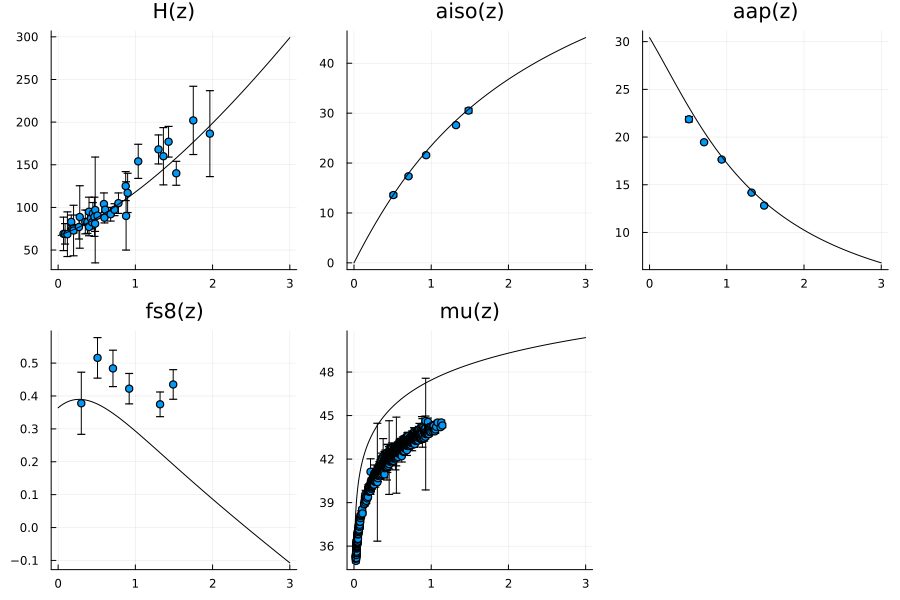

In [130]:
p0 = plot(datahz.z, datahz.data, yerr=hz_err, seriestype=:scatter,title="H(z)", legend=false)
p1 = plot(dataDESI.z_dvrd, dataDESI.data_dvrd, yerr=aiso_err, seriestype=:scatter,title="aiso(z)", legend=false)
p2 = plot(dataDESI.z_dhdm, dataDESI.data_dhdm, yerr=aap_err, seriestype=:scatter, title="aap(z)", legend=false)
p3 = plot(datafs8.z, datafs8.data, yerr=fs8_err, seriestype=:scatter, title="fs8(z)", legend=false)
p4 = plot(datamu.z, datamu.data, yerr=mu_err, seriestype=:scatter, title="mu(z)", legend=false)

plot!(p0, z_integ1, hz_from_ez(z_integ1, cosmo1.cpar.h, ez_test), color=:black)
plot!(p1, z_integ1, (dm_from_ez(z_integ1, cosmo1.cpar.h, ez_test) ./ rd_red), color=:black)
plot!(p2, z_integ1, (dh(z_integ1, cosmo1.cpar.h, ez_test) ./ rd_red), color=:black)
plot!(p3, z_integ1, fs8_from_ez(z_integ1, cosmo1.cpar.Ωm, cosmo1.cpar.σ8, cosmo1.cpar.h, ez_test, eltype(ez_test)), color=:black)
plot!(p4, z_integ1, mu(z_hel1, z_integ1, cosmo1.cpar.h, -19.3, ez_test), color=:black)

plot(p0, p1, p2, p3, p4, layout=(2,3), size=(900,600))

## LCDM analysis

In [ ]:
data_obs = [datahz.data; dataDESI.data];
z_obs = [datahz.z; dataDESI.z];
covariance_obs = BlockDiagonal([datahz.cov, dataDESI.cov]);

In [ ]:
@model function LCDM_model(data, data_cov)
    # Priors
    omegam_pr ~ omegam_dist
    h0_pr ~ h0_dist
    s8_pr ~ s8_dist
    rd_pr ~ rd_dist
    #M_pr ~ M_dist

    # Create cosmology
    cosmo_pr = LimberJack.Cosmology(Ωm=cosmo1.cpar.Ωm, Ωb=cosmo1.cpar.Ωb, h=cosmo1.cpar.h, σ8=s8_pr);
    
    # Model predictions
    ez_model = Ez(cosmo_pr, z_integ1)
    hz_model := hz_from_ez(z_integ1, h0_pr, ez_model)
    dv_rd_model := a_iso(z_integ1, h0_pr, rd_pr, ez_model) 
    dh_dm_model := a_ap(z_integ1, h0_pr, ez_model)
    fs8_model := fs8_from_ez(z_integ1, omegam_pr, s8_pr, h0_pr, ez_model, eltype(ez_model))
    #mu_model = mu(z_integ1, h0_pr, M_pr, ez_model)

    # Create interpolators
    hz_itp = LinearInterpolation(z_integ1, hz_model, extrapolation_bc=Line())
    dvrd_itp = LinearInterpolation(z_integ1, dv_rd_model, extrapolation_bc=Line())
    dhdm_itp = LinearInterpolation(z_integ1, dh_dm_model, extrapolation_bc=Line())
    fs8_itp = LinearInterpolation(z_integ1, fs8_model, extrapolation_bc=Line())
    #mu_itp = LinearInterpolation(z_integ1, mu_model, extrapolation_bc=Line())

    hz_theory := hz_itp(datahz.z)
    dvrd_theory := dvrd_itp(datafs8.z)
    dhdm_theory := dhdm_itp(datafs8.z)
    fs8_theory := fs8_itp(datafs8.z)
    #mu_theory := mu_itp(fakedatamu.z)

    theory = [hz_theory; dvrd_theory; dhdm_theory; fs8_theory]

    # Likelihood
    data ~ MvNormal(theory, data_cov)
end

In [ ]:
cond_LCDM_model = LCDM_model(data_obs, covariance_obs)
chain_LCDM = sample(cond_LCDM_model, NUTS(20, 0.7), 100)

In [ ]:
# lcdm chains
hzdata_lcdm = group(chain_LCDM, :hz_model).value.data[:,:,1];
aisodata_lcdm = group(chain_LCDM, :dv_rd_model).value.data[:,:,1];
aapdata_lcdm = group(chain_LCDM, :dh_dm_model).value.data[:,:,1];
fs8data_lcdm = group(chain_LCDM, :fs8_model).value.data[:,:,1];
#mudata_lcdm = group(chain_LCDM, :mu_model).value.data[:,:,1];

# mean and standard deviation - lcdm
hz_lcdm_m, hz_lcdm_s = mean(hzdata_lcdm, dims=1), std(hzdata_lcdm, dims=1); 
aiso_lcdm_m, aiso_lcdm_s = mean(aisodata_lcdm, dims=1), std(aisodata_lcdm, dims=1);
aap_lcdm_m, aap_lcdm_s = mean(aapdata_lcdm, dims=1), std(aapdata_lcdm, dims=1); 
fs8_lcdm_m, fs8_lcdm_s = mean(fs8data_lcdm, dims=1), std(fs8data_lcdm, dims=1); 
#mu_lcdm_m, mu_lcdm_s = mean(mudata_lcdm, dims=1), std(mudata_lcdm, dims=1); 

In [ ]:
plot(datahz.z, datahz.data, yerr=hz_err, label="Data H(z)", ms=2, seriestype=:scatter)
plot!(z_integ1, vec(hz_lcdm_m), label=" H(z) LCDM mean")
plot!(z_integ1, vec(hz_lcdm_m .- hz_lcdm_s),  fillrange = vec(hz_lcdm_m .+ hz_lcdm_s), fillalpha=0.2, c=1, label="H(z) LCDM standard deviation")

In [ ]:
plot(datafs8.z, dataDESI.data_dvrd, yerr=aiso_err, label="Data a_iso", ms=2, seriestype=:scatter)
plot!(z_integ1, vec(aiso_lcdm_m), label=" a_iso LCDM mean")
plot!(z_integ1, vec(aiso_lcdm_m .- aiso_lcdm_s),  fillrange = vec(aiso_lcdm_m .+ aiso_lcdm_s), fillalpha=0.2, c=1, label="a_iso LCDM standard deviation")

In [ ]:
plot(datafs8.z, dataDESI.data_dhdm, yerr=aap_err, label="Data a_ap", ms=2, seriestype=:scatter)
plot!(z_integ1, vec(aap_lcdm_m), label="a_ap LCDM mean")
plot!(z_integ1, vec(aap_lcdm_m .- aap_lcdm_s),  fillrange = vec(aap_lcdm_m .+ aap_lcdm_s), fillalpha=0.2, c=1, label="a_ap LCDM standard deviation")

In [ ]:
plot(datafs8.z, datafs8.data, yerr=fs8_err, label="Data fs8", ms=2, seriestype=:scatter)
plot!(z_integ1, vec(fs8_lcdm_m), label="fs8 lcdm")
plot!(z_integ1, vec(fs8_lcdm_m .- fs8_lcdm_s),  fillrange = vec(fs8_lcdm_m .+ fs8_lcdm_s), fillalpha=0.2, c=1, label="fs8 lcdm standard deviation")

In [ ]:
# plot(fakedatamu.z, fakedatamu.data, yerr=mu_err, label="Data mu", ms=2, seriestype=:scatter)
# plot!(z_integ1, vec(mu_lcdm_m), label="mu lcdm")
# plot!(z_integ1, vec(mu_lcdm_m .- mu_lcdm_s),  fillrange = vec(mu_lcdm_m .+ mu_lcdm_s), fillalpha=0.2, c=1, label="mu lcdm standard deviation")